# IMSC analysis and plots

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [2]:
figdir = os.path.join(figdirs, 'fig_jun24-imsc')


# 00. Plotting and reporting functions (move from here)

In [3]:
# model mean and range (not IQR)

def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  ax, 
                                                  year=2022, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 title=True):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.mean(dim='model')).values.T /unit
    lower_error = (da.mean(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))
    else:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))        
                          
    if proportion ==False:
        ax.set_ylabel(f'Number of people ({unit_str})')
        if title==True:
            ax.set_title(f'number of people experiencing at least n attributable hot days in {year}')
    else:
        ax.set_ylabel(f'Proportion of age group (%)')
        if title ==True:
            ax.set_title(f'proportion of age group experiencing at least n attributable hot days in {year}')
    
    ax.set_xlabel('Ages')
    step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges],  rotation='horizontal')
    if legend==True:
        ax.legend(labels = [f'at least {x}' for x in x_hot_days])

In [4]:
def plot_percapitadays_median_iqr(da, feature, ax):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      patch_artist=True,
                      showfliers=False) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
            patch.set_facecolor(col)
            patch.set_edgecolor(col)

    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], rotation='horizontal');
    plt.ylabel('Per capita attributable hot-humid days per year')
    plt.xlabel('Ages');

In [5]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

# 0. Population preprocessing

In [3]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2023,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

# 1. GCMs: empirical percentiles

In [6]:
# open climate data for 2023

dirname='output_empirical'
models='ISIMIP3b'

da_nAHD_WBGT28 = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_WBGT30 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_WBGT33 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname) # see here i coded what models it is in the fxn 

da_nAHD_WBGT90 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_WBGT95 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_WBGT99 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname) # see here i coded what models it is in the fxn 

da_nAHD_TX90 = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_TX95 = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname) # see here i coded what models it is in the fxn 
da_nAHD_TX99 = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname) # see here i coded what models it is in the fxn 



## 1a. WBGT28

In [26]:
# preprocess data with demographics
da_nAHD = da_nAHD_WBGT28

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


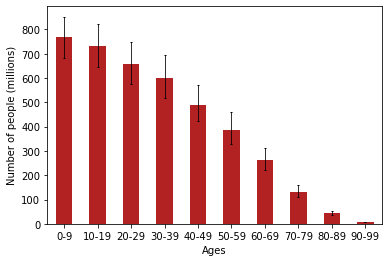

In [12]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_20'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

#plt.savefig(os.path.join(figdir,'n_people_atleast20_wbgt28.png'),dpi=300)

In [13]:
df_summary = df_summary_mean_range(da_n_people_ndays, feature='n_atleast_20',units=1e6)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,852.5,700.8,836.3,801.8,730.7,681.9,767.3,681.9,852.5
10,823.2,666.5,801.6,771.7,689.0,644.2,732.7,644.2,823.2
20,749.6,597.3,725.1,699.5,613.1,573.6,659.7,573.6,749.6
30,694.7,540.6,660.7,638.7,550.2,516.5,600.2,516.5,694.7
40,570.5,442.7,540.9,521.8,448.0,422.5,491.1,422.5,570.5
50,461.7,348.4,426.2,415.0,345.8,328.9,387.7,328.9,461.7
60,313.7,235.6,289.7,280.0,234.4,222.7,262.7,222.7,313.7
70,160.2,118.4,148.0,140.2,117.8,112.2,132.8,112.2,160.2
80,51.8,38.2,48.9,44.4,38.6,36.6,43.1,36.6,51.8


In [19]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

2.9208222306813854

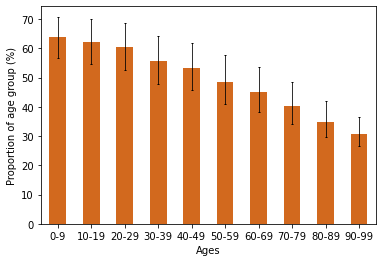

In [20]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_20') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

#plt.savefig(os.path.join(figdir,'prop_people_atleast20_wbgt28.png'),dpi=300)

In [22]:
df_summary = df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_20',units=100)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,70.8,58.2,69.4,66.6,60.7,56.6,63.7,56.6,70.8
10,70.0,56.7,68.1,65.6,58.6,54.8,62.3,54.8,70.0
20,68.8,54.8,66.5,64.2,56.2,52.6,60.5,52.6,68.8
30,64.3,50.0,61.1,59.1,50.9,47.8,55.5,47.8,64.3
40,62.0,48.1,58.7,56.7,48.7,45.9,53.3,45.9,62.0
50,57.7,43.5,53.2,51.8,43.2,41.1,48.4,41.1,57.7
60,53.7,40.3,49.6,47.9,40.1,38.1,45.0,38.1,53.7
70,48.5,35.8,44.8,42.4,35.7,33.9,40.2,33.9,48.5
80,41.9,30.9,39.6,36.0,31.3,29.7,34.9,29.7,41.9


In [23]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

1.4155555555555557

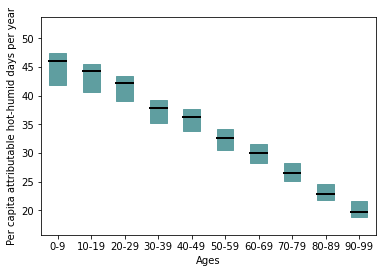

In [36]:
fig, ax = plt.subplots()

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

#plt.savefig(os.path.join(figdir,'percapita_days_wbgt28.png'),dpi=300)

In [44]:
df_summary = df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days')
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,median,Q1,Q3
age_ranges,,,,,,,,,
0,52.0,40.9,47.2,44.9,47.5,37.5,46.1,41.9,47.4
10,50.9,39.6,45.7,43.7,45.0,36.2,44.4,40.6,45.5
20,49.6,38.1,43.9,42.1,42.3,34.6,42.2,39.1,43.5
30,45.1,34.5,39.6,38.1,37.5,31.4,37.8,35.3,39.3
40,43.6,33.2,38.0,36.7,35.8,30.3,36.2,33.9,37.7
50,39.8,30.2,34.4,33.3,31.9,27.6,32.6,30.6,34.1
60,36.8,28.0,32.0,30.7,29.3,25.6,30.0,28.3,31.7
70,32.4,24.8,28.8,26.9,26.1,22.9,26.5,25.1,28.3
80,27.9,21.5,25.1,23.0,22.7,19.9,22.8,21.8,24.6


In [45]:
df_summary.loc[0, 'median'] / df_summary.loc[60, 'median']

1.5366666666666666

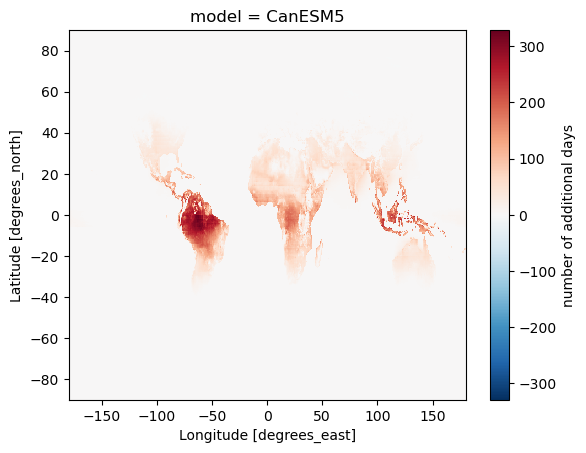

In [7]:
da_nAHD_WBGT28.isel(model=0).plot()

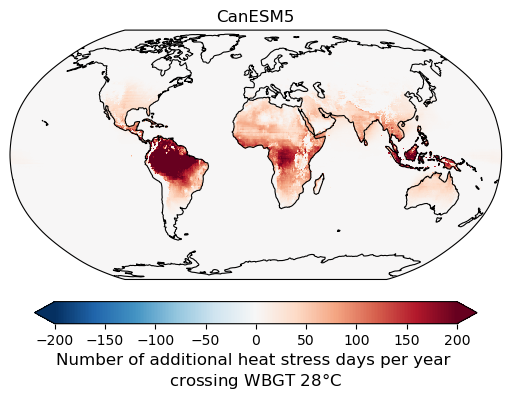

In [15]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

vmax = 200

# make figure object
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': proj},  layout='constrained')

data_plot = da_nAHD_WBGT28.isel(model=0)
plot = data_plot.plot( vmax=vmax, vmin=-vmax,  cmap='RdBu_r', transform=crs, extend='both', add_colorbar=False)
ax.coastlines(color='black', linewidth=0.8)

cbar_lab = 'Number of additional heat stress days per year \ncrossing WBGT 28$\degree$C' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.9) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab, size=12) 

plt.title(f'{data_plot.model.values}');

#plt.savefig(os.path.join(figdirs,f'fig_jun24_various/nAHD_CanESM.png'),dpi=300)


## 1b. TX99

In [95]:
# preprocess data with demographics
da_nAHD = da_nAHD_TX99

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


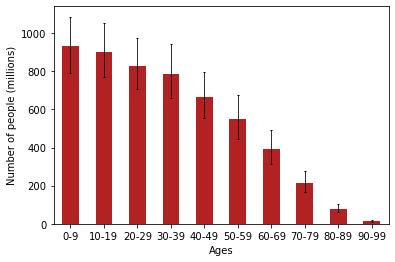

In [96]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_10'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

#plt.savefig(os.path.join(figdir,'n_people_atleast10_tx99.png'),dpi=300)

In [97]:
df_summary = df_summary_mean_range(da_n_people_ndays, feature='n_atleast_10',units=1e6)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,843.0,968.9,954.0,792.9,1085.8,950.1,932.5,792.9,1085.8
10,810.2,939.2,926.5,768.6,1054.6,918.7,903.0,768.6,1054.6
20,738.2,861.5,852.3,705.7,974.0,841.3,828.8,705.7,974.0
30,676.4,820.2,825.6,662.1,940.4,803.4,788.0,662.1,940.4
40,561.2,686.3,698.4,557.0,798.5,676.4,663.0,557.0,798.5
50,445.4,565.7,594.6,451.3,673.3,567.1,549.6,445.4,673.3
60,311.5,399.8,425.0,325.4,491.1,402.9,392.6,311.5,491.1
70,166.4,216.1,236.2,177.8,277.0,222.6,216.0,166.4,277.0
80,60.1,76.6,87.7,66.5,105.6,82.2,79.8,60.1,105.6


In [98]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

2.3751910341314315

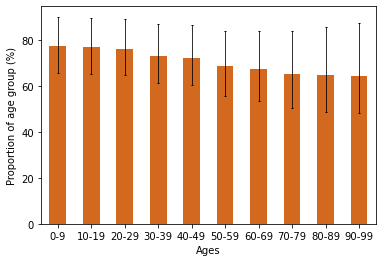

In [99]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_10') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

#plt.savefig(os.path.join(figdir,'prop_people_atleast10_tx99.png'),dpi=300)

In [100]:
df_summary = df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_10',units=100)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,70.0,80.4,79.2,65.8,90.1,78.9,77.4,65.8,90.1
10,68.9,79.8,78.8,65.3,89.6,78.1,76.8,65.3,89.6
20,67.7,79.0,78.2,64.7,89.3,77.2,76.0,64.7,89.3
30,62.6,75.9,76.4,61.3,87.0,74.3,72.9,61.3,87.0
40,60.9,74.5,75.8,60.5,86.7,73.5,72.0,60.5,86.7
50,55.6,70.7,74.3,56.4,84.1,70.8,68.6,55.6,84.1
60,53.3,68.4,72.7,55.7,84.0,69.0,67.2,53.3,84.0
70,50.4,65.4,71.5,53.8,83.8,67.4,65.4,50.4,83.8
80,48.7,62.0,71.1,53.9,85.6,66.6,64.6,48.7,85.6


In [101]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

1.1517857142857144

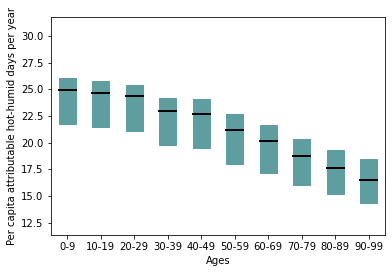

In [102]:
fig, ax = plt.subplots()

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

plt.savefig(os.path.join(figdir,'percapita_days_tx99.png'),dpi=300)

In [103]:
df_summary = df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days')
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,median,Q1,Q3
age_ranges,,,,,,,,,
0,21.0,26.0,26.1,16.5,34.5,24.0,25.0,21.7,26.1
10,20.7,25.7,25.8,16.4,33.9,23.7,24.7,21.4,25.8
20,20.4,25.4,25.5,16.3,33.2,23.3,24.3,21.1,25.4
30,19.0,23.8,24.4,15.5,31.1,22.1,23.0,19.8,24.2
40,18.7,23.5,24.2,15.4,30.8,21.9,22.7,19.5,24.0
50,17.2,21.8,23.0,14.5,28.7,20.5,21.2,18.0,22.7
60,16.4,20.8,22.0,14.0,27.5,19.5,20.2,17.2,21.7
70,15.2,19.2,20.7,13.3,25.9,18.3,18.7,16.0,20.4
80,14.4,17.8,19.8,12.9,24.8,17.4,17.6,15.2,19.3


In [104]:
df_summary.loc[0, 'median'] / df_summary.loc[60, 'median']

1.2376237623762376

<AxesSubplot:xlabel='age_ranges'>

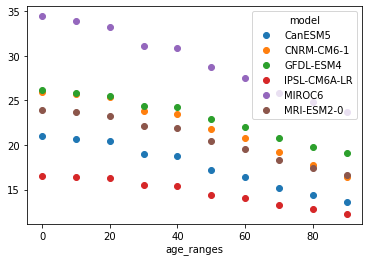

In [105]:
da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T.plot(marker='o',linestyle='None')

## 1b.1 TX99 from 2022 

In [106]:
da_nAHD_TX99_2022 = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year=2022)


In [78]:
# preprocess data with demographics
da_nAHD = da_nAHD_TX99_2022
da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


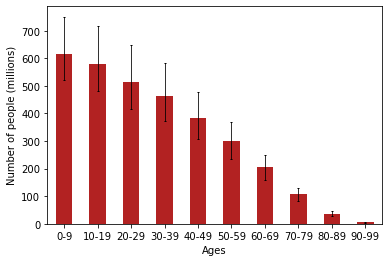

In [79]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_10'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

#plt.savefig(os.path.join(figdir,'n_people_atleast10_tx99.png'),dpi=300)

In [80]:
df_summary = df_summary_mean_range(da_n_people_ndays, feature='n_atleast_10',units=1e6)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,750.7,635.1,558.5,671.3,562.9,520.0,616.4,520.0,750.7
10,717.8,590.0,531.8,631.8,521.3,479.6,578.7,479.6,717.8
20,649.1,517.1,476.9,562.0,456.7,416.4,513.0,416.4,649.1
30,583.4,467.4,462.3,495.3,408.8,373.1,465.0,373.1,583.4
40,478.4,384.8,389.7,401.9,335.7,306.8,382.9,306.8,478.4
50,368.4,301.1,331.9,301.8,257.0,236.1,299.4,236.1,368.4
60,251.1,207.8,231.3,203.8,177.8,160.1,205.3,160.1,251.1
70,128.5,108.2,127.6,102.4,93.3,82.1,107.0,82.1,128.5
80,43.8,37.2,45.4,34.0,33.2,28.0,36.9,28.0,45.4


In [81]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

3.0024354603019967

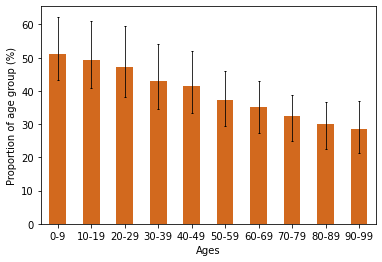

In [82]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_10') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

#plt.savefig(os.path.join(figdir,'prop_people_atleast10_tx99.png'),dpi=300)

In [83]:
df_summary = df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_10',units=100)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,62.3,52.7,46.4,55.7,46.7,43.2,51.2,43.2,62.3
10,61.0,50.2,45.2,53.7,44.3,40.8,49.2,40.8,61.0
20,59.5,47.4,43.7,51.5,41.9,38.2,47.1,38.2,59.5
30,54.0,43.2,42.8,45.8,37.8,34.5,43.0,34.5,54.0
40,51.9,41.8,42.3,43.6,36.5,33.3,41.6,33.3,51.9
50,46.0,37.6,41.5,37.7,32.1,29.5,37.4,29.5,46.0
60,43.0,35.6,39.6,34.9,30.4,27.4,35.1,27.4,43.0
70,38.9,32.8,38.6,31.0,28.2,24.8,32.4,24.8,38.9
80,35.5,30.1,36.8,27.6,26.9,22.7,29.9,22.7,36.8


In [84]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

1.4586894586894588

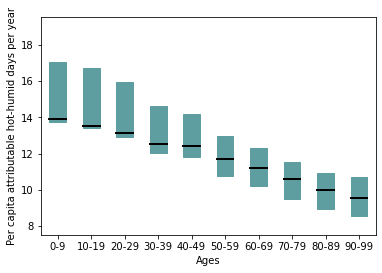

In [85]:
fig, ax = plt.subplots()

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

plt.savefig(os.path.join(figdir,'percapita_days_tx99.png'),dpi=300)

In [86]:
df_summary = df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days')
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,median,Q1,Q3
age_ranges,,,,,,,,,
0,18.0,13.9,13.7,13.6,19.0,14.0,13.9,13.7,17.0
10,17.8,13.4,13.5,13.1,17.9,13.5,13.5,13.4,16.7
20,17.6,12.9,13.3,12.7,16.9,13.0,13.1,12.9,16.0
30,16.3,12.0,12.9,11.7,15.2,12.2,12.5,12.0,14.6
40,16.0,11.7,12.9,11.4,14.7,12.0,12.4,11.8,14.2
50,14.7,10.7,12.5,10.4,13.1,11.0,11.7,10.8,13.0
60,14.0,10.2,12.0,9.9,12.4,10.4,11.2,10.2,12.3
70,12.9,9.5,11.5,9.2,11.5,9.7,10.6,9.5,11.5
80,12.1,8.9,10.9,8.6,10.9,9.1,10.0,9.0,10.9


In [87]:
df_summary.loc[0, 'median'] / df_summary.loc[60, 'median']

1.2410714285714286

<AxesSubplot:xlabel='age_ranges'>

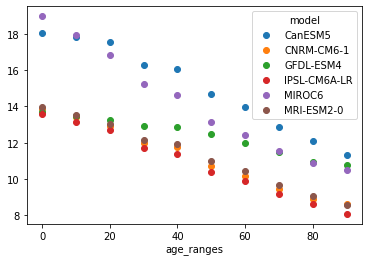

In [94]:
da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T.plot(marker='o',linestyle='None')

### compare what is going on

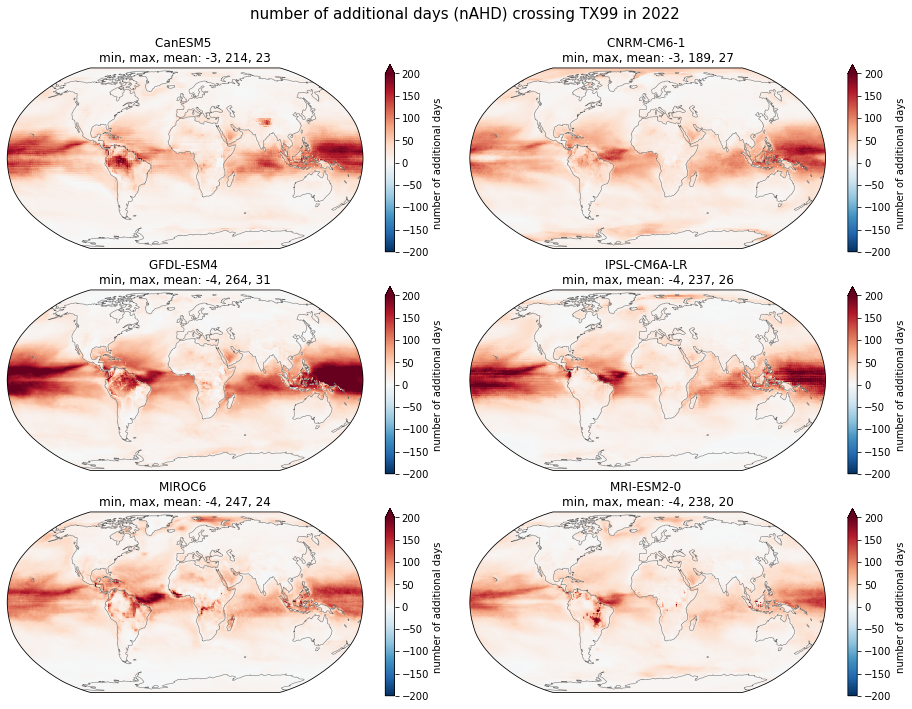

In [108]:
da_nAHD = da_nAHD_TX99_2022

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 200
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of additional days (nAHD) crossing TX99 in 2022\n', size=15);
fig.tight_layout()

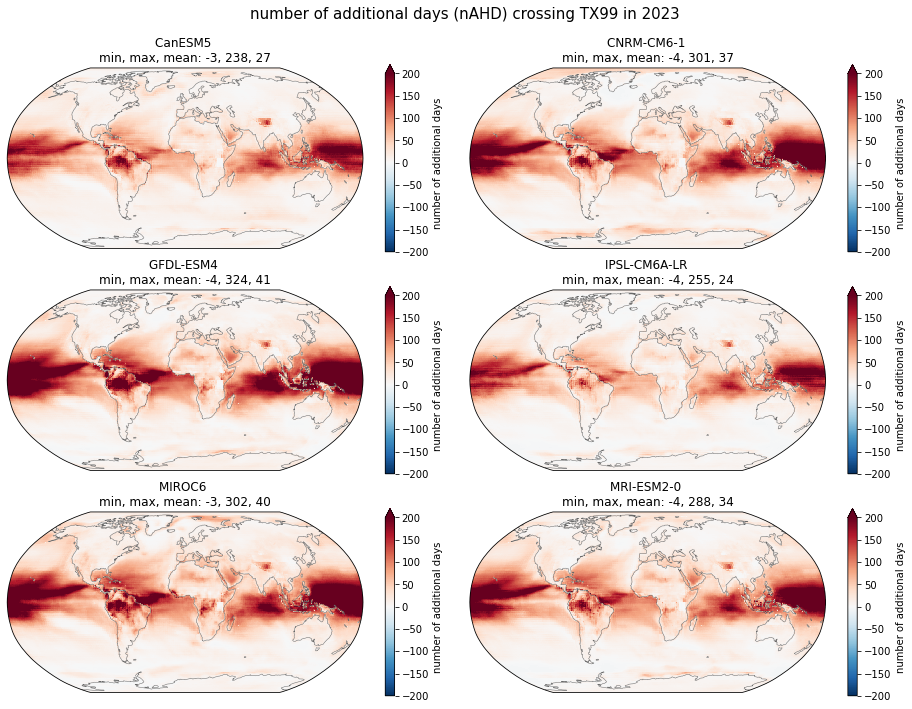

In [110]:
da_nAHD = da_nAHD_TX99

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 200
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of additional days (nAHD) crossing TX99 in 2023\n', size=15);
fig.tight_layout()

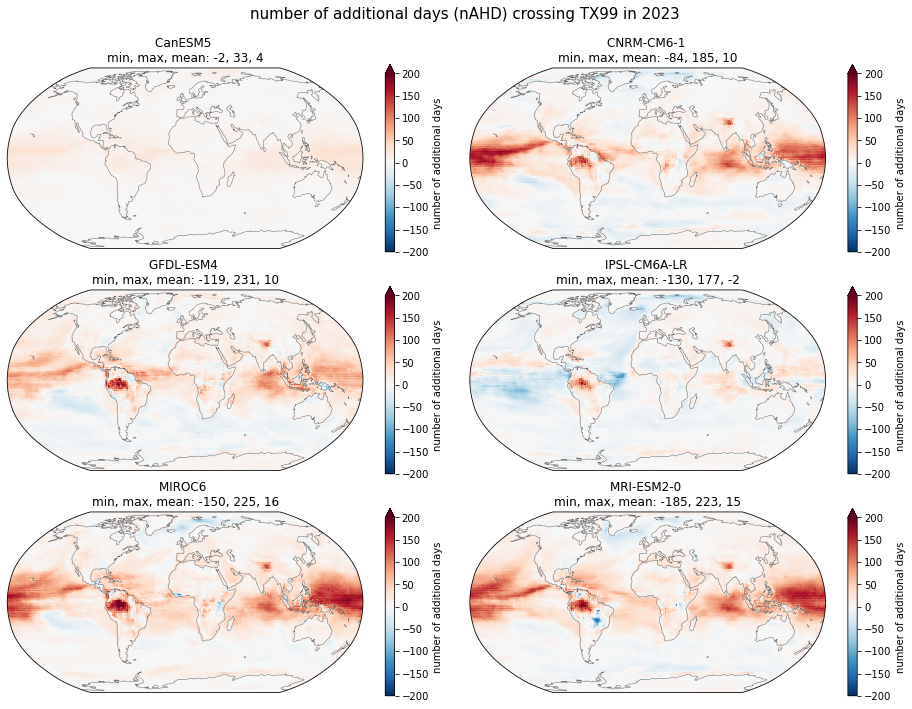

In [112]:


da_nAHD = da_nAHD_TX99 - da_nAHD_TX99_2022

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 200
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of additional days (nAHD) crossing TX99 in 2023 minus 2022\n', size=15);
fig.tight_layout()


## 1c. TX95

In [95]:
# preprocess data with demographics
da_nAHD = da_nAHD_TX95

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


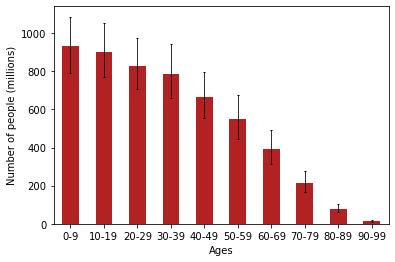

In [96]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays.sel(features='n_atleast_10'), 
                                              unit=1e6,  
                                              ax=ax, 
                                              proportion=False, 
                                              legend=False,
                                              errcolor='k',
                                              color='firebrick',
                                              title=False)

#plt.savefig(os.path.join(figdir,'n_people_atleast10_tx99.png'),dpi=300)

In [97]:
df_summary = df_summary_mean_range(da_n_people_ndays, feature='n_atleast_10',units=1e6)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,843.0,968.9,954.0,792.9,1085.8,950.1,932.5,792.9,1085.8
10,810.2,939.2,926.5,768.6,1054.6,918.7,903.0,768.6,1054.6
20,738.2,861.5,852.3,705.7,974.0,841.3,828.8,705.7,974.0
30,676.4,820.2,825.6,662.1,940.4,803.4,788.0,662.1,940.4
40,561.2,686.3,698.4,557.0,798.5,676.4,663.0,557.0,798.5
50,445.4,565.7,594.6,451.3,673.3,567.1,549.6,445.4,673.3
60,311.5,399.8,425.0,325.4,491.1,402.9,392.6,311.5,491.1
70,166.4,216.1,236.2,177.8,277.0,222.6,216.0,166.4,277.0
80,60.1,76.6,87.7,66.5,105.6,82.2,79.8,60.1,105.6


In [98]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

2.3751910341314315

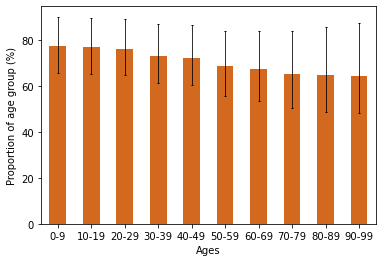

In [99]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays.sel(features='prop_atleast_10') * 100, 
                                              unit=1,  
                                              ax=ax, 
                                              proportion=True, 
                                              legend=False,
                                              errcolor='k',
                                              color='chocolate',
                                              title=False)

#plt.savefig(os.path.join(figdir,'prop_people_atleast10_tx99.png'),dpi=300)

In [100]:
df_summary = df_summary_mean_range(da_prop_people_ndays, feature='prop_atleast_10',units=100)
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,mean,min,max
age_ranges,,,,,,,,,
0,70.0,80.4,79.2,65.8,90.1,78.9,77.4,65.8,90.1
10,68.9,79.8,78.8,65.3,89.6,78.1,76.8,65.3,89.6
20,67.7,79.0,78.2,64.7,89.3,77.2,76.0,64.7,89.3
30,62.6,75.9,76.4,61.3,87.0,74.3,72.9,61.3,87.0
40,60.9,74.5,75.8,60.5,86.7,73.5,72.0,60.5,86.7
50,55.6,70.7,74.3,56.4,84.1,70.8,68.6,55.6,84.1
60,53.3,68.4,72.7,55.7,84.0,69.0,67.2,53.3,84.0
70,50.4,65.4,71.5,53.8,83.8,67.4,65.4,50.4,83.8
80,48.7,62.0,71.1,53.9,85.6,66.6,64.6,48.7,85.6


In [101]:
df_summary.loc[0, 'mean'] / df_summary.loc[60, 'mean']

1.1517857142857144

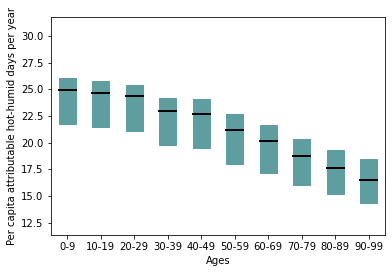

In [102]:
fig, ax = plt.subplots()

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y,
                              feature='per_capita_days',
                              ax=ax)

plt.savefig(os.path.join(figdir,'percapita_days_tx99.png'),dpi=300)

In [103]:
df_summary = df_summary_median_iqr(da_nAHD_percapita_peopledays_10y, feature='per_capita_days')
df_summary

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,median,Q1,Q3
age_ranges,,,,,,,,,
0,21.0,26.0,26.1,16.5,34.5,24.0,25.0,21.7,26.1
10,20.7,25.7,25.8,16.4,33.9,23.7,24.7,21.4,25.8
20,20.4,25.4,25.5,16.3,33.2,23.3,24.3,21.1,25.4
30,19.0,23.8,24.4,15.5,31.1,22.1,23.0,19.8,24.2
40,18.7,23.5,24.2,15.4,30.8,21.9,22.7,19.5,24.0
50,17.2,21.8,23.0,14.5,28.7,20.5,21.2,18.0,22.7
60,16.4,20.8,22.0,14.0,27.5,19.5,20.2,17.2,21.7
70,15.2,19.2,20.7,13.3,25.9,18.3,18.7,16.0,20.4
80,14.4,17.8,19.8,12.9,24.8,17.4,17.6,15.2,19.3


In [104]:
df_summary.loc[0, 'median'] / df_summary.loc[60, 'median']

1.2376237623762376